In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 ANOMALY DETECTION - PIPELINE OPTIMIZAT CU TUNING

 Step 1: Loading datasets...
 Loading Normal...
    Shape: (4193, 13)
 Loading Ramp-up...
    Shape: (6172, 13)
 Loading Medium Load...
    Shape: (5031, 13)
 Loading High Load...
    Shape: (4071, 13)

 Step 2: Feature engineering...
    Features created: 19 features

 Step 3: Feature scaling...
   Training set (Normal): (4193, 19)

 Step 4: Creating Mixed Validation/Test Sets...
   Mixed Validation (Medium) set size: (6037, 19)
   Mixed Test (High) set size: (4885, 19)

 MODEL TRAINING: ISOLATION FOREST

 Tuning Isolation Forest Contamination...
   Cont=0.03: F1-Score=0.9667
   Cont=0.05: F1-Score=0.9651
   Cont=0.08: F1-Score=0.9617
   Cont=0.10: F1-Score=0.9594
   Cont=0.12: F1-Score=0.9576
   Cont=0.15: F1-Score=0.9721

 Best Contamination Selected: 0.15  Best F1: 0.9721

 EVALUATION: Isolation Forest on Medium Load (Validation) (MIXED)
Precision: 0.9703
Recall:    0.9740
F1-Score:  0.9721
ROC-AUC:   0.9912

Confusion Matrix:
    

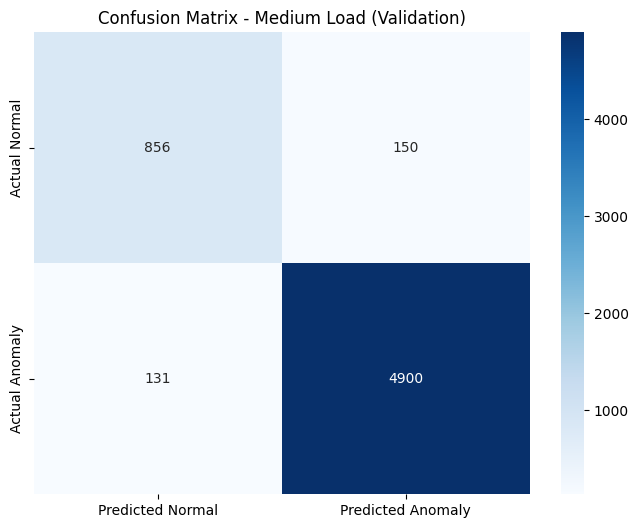

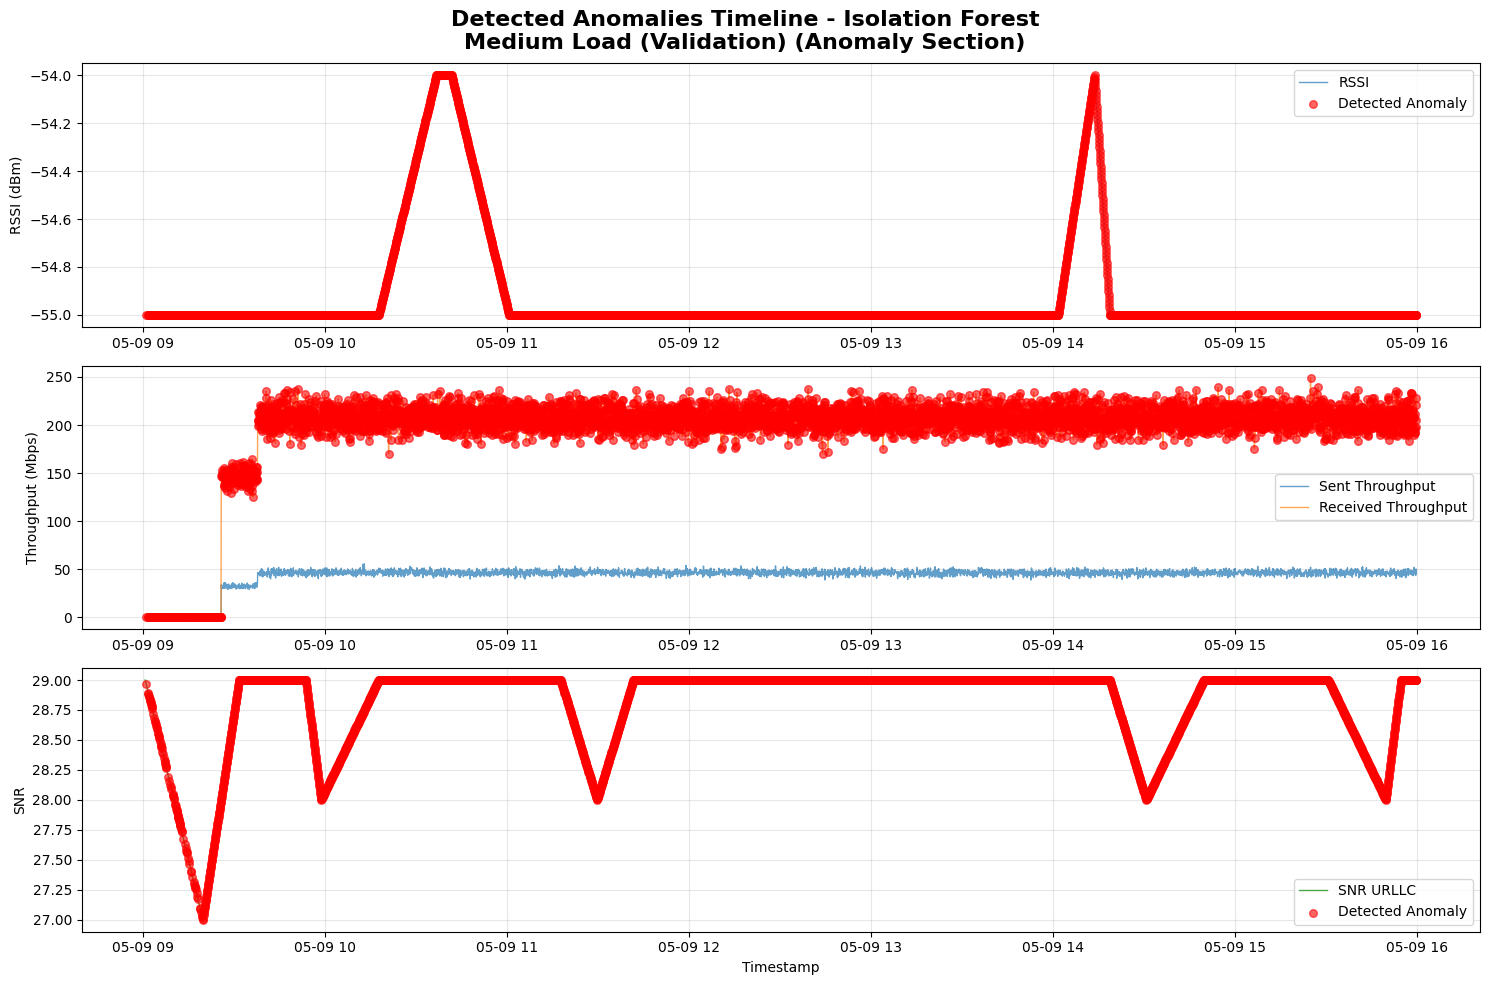


 EVALUATION: Isolation Forest on High Load (Test) (MIXED)
Precision: 0.9705
Recall:    0.9762
F1-Score:  0.9733
ROC-AUC:   0.9825

Confusion Matrix:
              precision    recall  f1-score   support

  Normal (0)       0.88      0.85      0.86       814
 Anomaly (1)       0.97      0.98      0.97      4071

    accuracy                           0.96      4885
   macro avg       0.92      0.91      0.92      4885
weighted avg       0.95      0.96      0.96      4885



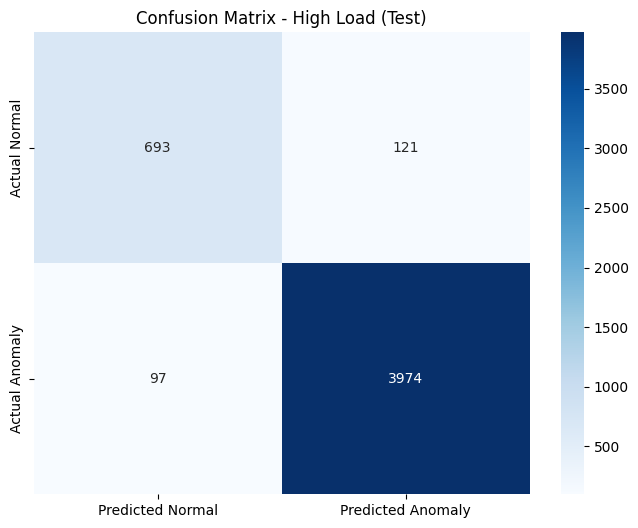

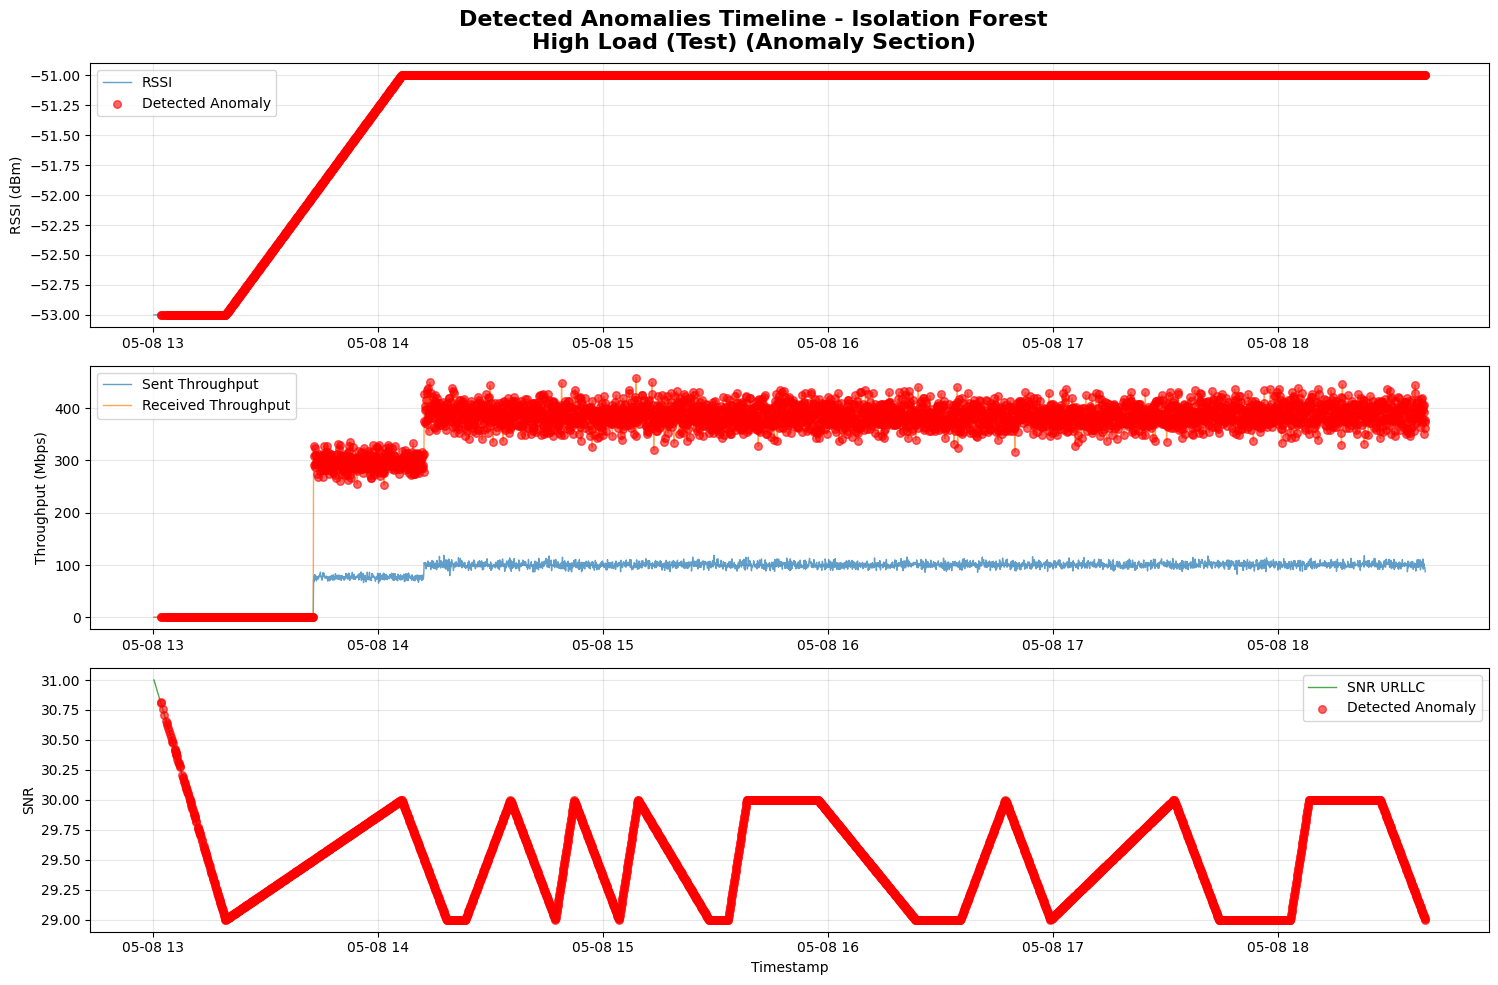

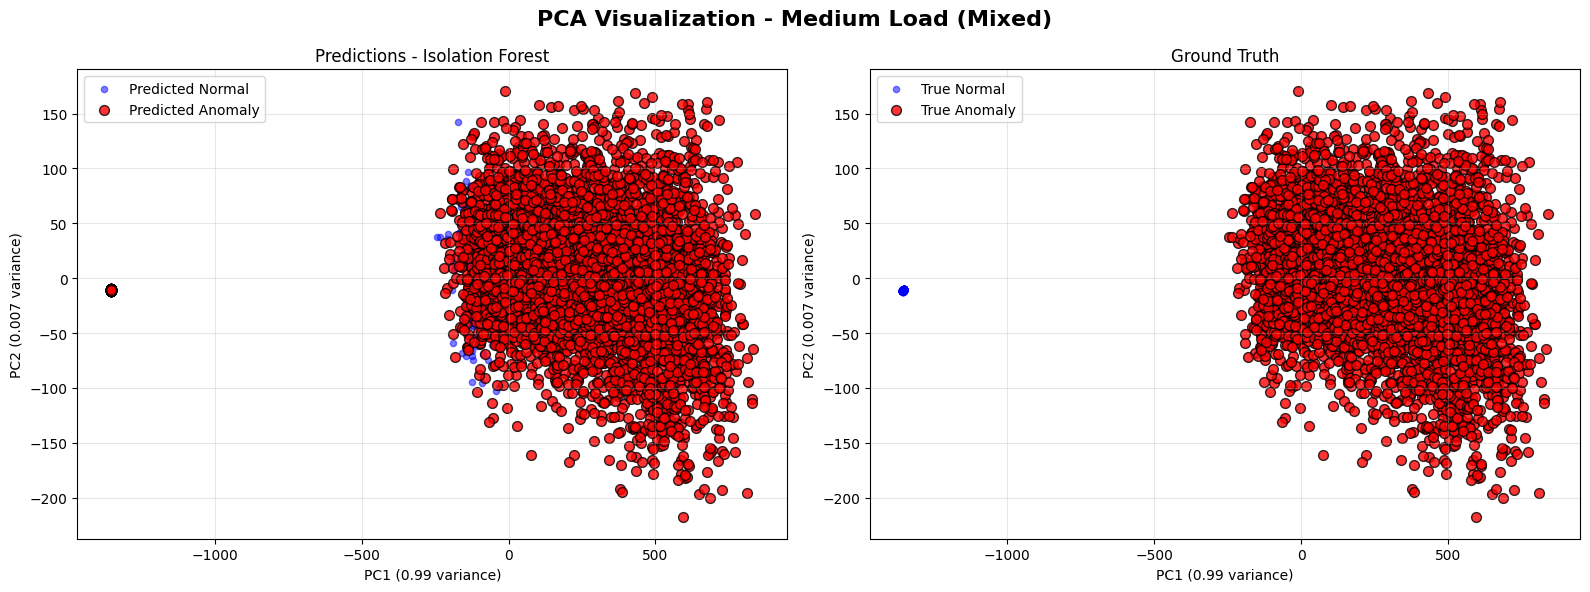


 Step 7: Saving model artifacts...
 Model saved: /content/drive/MyDrive/AnomalyDetection/models/isolation_forest_model_20251211_125206.pkl
 Scaler saved: /content/drive/MyDrive/AnomalyDetection/models/isolation_forest_scaler_20251211_125206.pkl
 Config saved: /content/drive/MyDrive/AnomalyDetection/models/isolation_forest_config_20251211_125206.json

 TRAINING COMPLETE - SUMMARY

 Isolation Forest (Contamination=0.15):
   - Medium Load F1-Score: 0.9721, ROC-AUC: 0.9912
   - High Load F1-Score: 0.9733, ROC-AUC: 0.9825

 Model Artifacts:
   - Model: /content/drive/MyDrive/AnomalyDetection/models/isolation_forest_model_20251211_125206.pkl
   - Scaler: /content/drive/MyDrive/AnomalyDetection/models/isolation_forest_scaler_20251211_125206.pkl
   - Config: /content/drive/MyDrive/AnomalyDetection/models/isolation_forest_config_20251211_125206.json


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.decomposition import PCA
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

paths = {
    'normal': "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_normal_processed.csv",
    'medium': "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_medium_processed.csv",
    'high': "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_high_processed.csv",
    'ramp': "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_normal-medium_ramp-up_processed-1.csv"
}

useful_cols = [
    'timestamp', 'RSSI', 'SNRCurrent_URLLC', 'RSRPCurrent_URLLC',
    'BytesSent_URLLC', 'BytesReceived_URLLC', 'URLLC_BytesSent',
    'URLLC_BytesReceived', 'URLLC_Sent_thrp_Mbps', 'URLLC_Received_thrp_Mbps'
]


def load_and_prepare_data(path, scenario_name):
    """Incarca si pregateste datele"""
    print(f" Loading {scenario_name}...")
    df = pd.read_csv(path)
    df_clean = df[useful_cols].copy()
    df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

    # Features temporale
    df_clean['hour'] = df_clean['timestamp'].dt.hour
    df_clean['minute'] = df_clean['timestamp'].dt.minute
    df_clean['second'] = df_clean['timestamp'].dt.second

    # Fill missing values
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')

    print(f"    Shape: {df_clean.shape}")
    return df_clean

def create_refined_features(df):
    """
    Creeaza features optimizate pentru a evidentia anomaliile subtile (Medium Load).
    Include eficienta semnalului si volatilitatea.
    """
    feat = df.copy()

    # Features numerice de baza
    numeric_cols = ['RSSI', 'SNRCurrent_URLLC', 'RSRPCurrent_URLLC',
                    'BytesSent_URLLC', 'BytesReceived_URLLC',
                    'URLLC_Sent_thrp_Mbps', 'URLLC_Received_thrp_Mbps']

    #  Eficienta Semnal (Throughput per unit of Signal)
    # Folosim abs(RSSI) pentru ca este o valoare negativa (dBm)
    feat['thrp_efficiency'] = feat['URLLC_Received_thrp_Mbps'] / (np.abs(feat['RSSI']) + 0.1)

    # Volatilitate (Rolling Standard Deviation)
    # Fluctuatiile mari pe termen scurt indica instabilitate
    feat['rssi_volatility_5'] = feat['RSSI'].rolling(window=5).std().fillna(0)
    feat['snr_volatility_5'] = feat['SNRCurrent_URLLC'].rolling(window=5).std().fillna(0)

    # Rate of Change
    feat['rssi_diff'] = feat['RSSI'].diff().fillna(0)

    # Rolling statistics (Mean  Range)
    windows = [10, 20]
    for metric in ['RSSI', 'URLLC_Received_thrp_Mbps']:
        for window in windows:
            feat[f'{metric}_roll_mean_{window}'] = (
                feat[metric].rolling(window=window, min_periods=1).mean()
            )
            feat[f'{metric}_roll_range_{window}'] = (
                feat[metric].rolling(window=window, min_periods=1).max() -
                feat[metric].rolling(window=window, min_periods=1).min()
            )

    # ne asiguram ca nu exista Inf/-Inf
    feat = feat.replace([np.inf, -np.inf], 0).fillna(0)

    # Selectam coloanele numerice finale
    final_cols = [col for col in feat.columns if col not in ['timestamp', 'hour', 'minute', 'second', 'URLLC_BytesSent', 'URLLC_BytesReceived'] and feat[col].dtype != 'object']

    return feat[final_cols]


def prepare_mixed_test_set(normal_features, anomaly_features, ratio=0.2):
    """Mixeaza date normale in setul de anomalii pentru a calcula ROC-AUC corect"""
    n_normal = int(len(anomaly_features) * ratio)

    # Evita data leakage, mostrele normale vin din df_normal
    normal_sample = normal_features.sample(n=n_normal, random_state=42)

    X_test = pd.concat([normal_sample, anomaly_features], ignore_index=True)
    # 0 = Normal (True Negative), 1 = Anomaly (True Positive)
    y_test = np.array([0] * len(normal_sample) + [1] * len(anomaly_features))

    # Retine indexul original al datelor de anomalie pentru vizualizari (cele mai mari)
    anomaly_indices_in_mixed = np.where(y_test == 1)[0]

    return X_test, y_test, anomaly_indices_in_mixed

def train_optimized_iforest(X_train, X_val, y_val):
    """Gaseste contaminarea optima pentru a maximiza F1-Score pe setul de validare (Medium)"""
    best_f1 = -1
    best_model = None
    best_cont = 0

    print("\n Tuning Isolation Forest Contamination...")
    # Testam diverse praguri de sensibilitate, incluzand valori mai mari pentru a prinde Medium Load
    contamination_levels = [0.03, 0.05, 0.08, 0.1, 0.12, 0.15]

    for cont in contamination_levels:
        model = IsolationForest(contamination=cont, random_state=42, n_jobs=-1)
        model.fit(X_train)

        # Predict pe setul de validare (Medium Load)
        preds = model.predict(X_val)
        y_pred = np.where(preds == -1, 1, 0)  # -1 (Anomaly) -> 1

        current_f1 = f1_score(y_val, y_pred, zero_division=0)

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_model = model
            best_cont = cont

        print(f"   Cont={cont:.2f}: F1-Score={current_f1:.4f}")

    print(f"\n Best Contamination Selected: {best_cont}  Best F1: {best_f1:.4f}")
    return best_model, best_cont

def evaluate_and_plot(X_eval, y_eval, model, scaler, scenario_name, time_df_original):
    """Evalueaza si ploteaza rezultatele pentru un set de test mixt."""
    X_scaled = scaler.transform(X_eval)

    # Obtine predictiile si scorurile de anomalie (scoruri mai mari = mai anomale)
    preds = model.predict(X_scaled)
    y_pred = np.where(preds == -1, 1, 0)  # -1 (Anomaly) -> 1
    scores = -model.decision_function(X_scaled)

    # Metrici
    precision = precision_score(y_eval, y_pred, zero_division=0)
    recall = recall_score(y_eval, y_pred, zero_division=0)
    f1 = f1_score(y_eval, y_pred, zero_division=0)

    # ROC-AUC (posibil daca y_eval contine ambele clase, 0 si 1)
    try:
        roc_auc = roc_auc_score(y_eval, scores)
    except ValueError:
        roc_auc = np.nan

    print(f"\n{'='*60}")
    print(f" EVALUATION: Isolation Forest on {scenario_name} (MIXED)")
    print(f"{'='*60}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_eval, y_pred)
    print(f"\nConfusion Matrix:")
    print(classification_report(y_eval, y_pred,
                                target_names=['Normal (0)', 'Anomaly (1)'],
                                zero_division=0))

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal', 'Predicted Anomaly'],
                yticklabels=['Actual Normal', 'Actual Anomaly'])
    plt.title(f'Confusion Matrix - {scenario_name}')
    plt.show()

    # Ploteaza anomaliile pe timeline (doar pentru portiunea de anomalii din setul mixt)
    # Aceasta sectiune necesita o mapare mai complexa, o simplificam:
    plot_timeline_comparison_mixed(time_df_original, y_pred, y_eval, scenario_name)

    return {
        'precision': precision, 'recall': recall, 'f1_score': f1, 'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

def plot_timeline_comparison_mixed(df_test, y_pred_mixed, y_true_mixed, scenario_name):
    """
    Ploteaza anomaliile pe timeline.
    Necesita maparea inapoi la DataFrame-ul original (care nu este mixt).
    Se afiseaza doar sectiunea Anomaly (1) din setul mixt.
    """

    # Identificam indicii reali ai datelor de anomalie (unde y_true_mixed este 1)
    true_anomaly_indices = np.where(y_true_mixed == 1)[0]

    # Extragem doar predictiile care corespund datelor de anomalie
    y_pred_anomaly_only = y_pred_mixed[true_anomaly_indices]

    # Asiguram ca df_test este doar DataFrame-ul original (Medium sau High)
    df_plot = df_test.iloc[0:len(y_pred_anomaly_only)].reset_index(drop=True)

    # Masca de anomalie detectata (-1 in IF original, 1 in y_pred)
    anomaly_mask = y_pred_anomaly_only == 1

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    fig.suptitle(f'Detected Anomalies Timeline - Isolation Forest\n{scenario_name} (Anomaly Section)',
                 fontsize=16, fontweight='bold')

    # RSSI
    axes[0].plot(df_plot['timestamp'], df_plot['RSSI'], label='RSSI', alpha=0.7, linewidth=1)
    axes[0].scatter(df_plot.loc[anomaly_mask, 'timestamp'],
                   df_plot.loc[anomaly_mask, 'RSSI'],
                   color='red', s=30, label='Detected Anomaly', zorder=5, alpha=0.6)
    axes[0].set_ylabel('RSSI (dBm)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Throughput
    axes[1].plot(df_plot['timestamp'], df_plot['URLLC_Sent_thrp_Mbps'],
                 label='Sent Throughput', alpha=0.7, linewidth=1)
    axes[1].plot(df_plot['timestamp'], df_plot['URLLC_Received_thrp_Mbps'],
                 label='Received Throughput', alpha=0.7, linewidth=1)
    axes[1].scatter(df_plot.loc[anomaly_mask, 'timestamp'],
                   df_plot.loc[anomaly_mask, 'URLLC_Received_thrp_Mbps'],
                   color='red', s=30, zorder=5, alpha=0.6)
    axes[1].set_ylabel('Throughput (Mbps)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # SNR
    axes[2].plot(df_plot['timestamp'], df_plot['SNRCurrent_URLLC'],
                 label='SNR URLLC', alpha=0.7, color='green', linewidth=1)
    axes[2].scatter(df_plot.loc[anomaly_mask, 'timestamp'],
                   df_plot.loc[anomaly_mask, 'SNRCurrent_URLLC'],
                   color='red', s=30, label='Detected Anomaly', zorder=5, alpha=0.6)
    axes[2].set_xlabel('Timestamp')
    axes[2].set_ylabel('SNR')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_pca_visualization(X_scaled, y_pred, y_true, scenario_name, model_name):
    """Vizualizeaza rezultatele in spatiul PCA"""
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Predicted anomalies
    normal_mask_pred = y_pred == 0
    anomaly_mask_pred = y_pred == 1

    ax1.scatter(X_pca[normal_mask_pred, 0], X_pca[normal_mask_pred, 1],
               c='blue', alpha=0.5, label='Predicted Normal', s=20)
    ax1.scatter(X_pca[anomaly_mask_pred, 0], X_pca[anomaly_mask_pred, 1],
               c='red', alpha=0.8, label='Predicted Anomaly', s=50, edgecolors='black')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2} variance)')
    ax1.set_title(f'Predictions - {model_name}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # True labels
    normal_mask_true = y_true == 0
    anomaly_mask_true = y_true == 1

    ax2.scatter(X_pca[normal_mask_true, 0], X_pca[normal_mask_true, 1],
               c='blue', alpha=0.5, label='True Normal', s=20)
    ax2.scatter(X_pca[anomaly_mask_true, 0], X_pca[anomaly_mask_true, 1],
               c='red', alpha=0.8, label='True Anomaly', s=50, edgecolors='black')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2} variance)')
    ax2.set_title(f'Ground Truth')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    fig.suptitle(f'PCA Visualization - {scenario_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def save_model_artifacts(model, scaler, feature_names, contamination, model_name='isolation_forest', save_dir='/content/drive/MyDrive/AnomalyDetection/models'):
    """Salveaza modelul si artefactele"""
    import os
    os.makedirs(save_dir, exist_ok=True)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Salveaza modelul
    model_path = f'{save_dir}/{model_name}_model_{timestamp}.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f" Model saved: {model_path}")

    # Salveaza scaler
    scaler_path = f'{save_dir}/{model_name}_scaler_{timestamp}.pkl'
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f" Scaler saved: {scaler_path}")

    # Salveaza feature config
    config = {
        'feature_names': feature_names,
        'n_features': len(feature_names),
        'model_type': model_name,
        'contamination_tuned': contamination,
        'timestamp': timestamp,
        'training_date': datetime.now().isoformat()
    }
    config_path = f'{save_dir}/{model_name}_config_{timestamp}.json'
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f" Config saved: {config_path}")

    return model_path, scaler_path, config_path


print("="*80)
print(" ANOMALY DETECTION - PIPELINE OPTIMIZAT CU TUNING")
print("="*80)

# 1. INCARCA DATELE
print("\n Step 1: Loading datasets...")
df_normal = load_and_prepare_data(paths['normal'], 'Normal')
df_ramp = load_and_prepare_data(paths['ramp'], 'Ramp-up')
df_medium = load_and_prepare_data(paths['medium'], 'Medium Load')
df_high = load_and_prepare_data(paths['high'], 'High Load')

# 2. CREEAZA FEATURES REFINATE
print("\n Step 2: Feature engineering...")
# Antreneaza doar pe datele de baza, cele de ramp-up pot introduce zgomot
X_train_raw = create_refined_features(df_normal)
X_medium_raw = create_refined_features(df_medium)
X_high_raw = create_refined_features(df_high)

print(f"    Features created: {X_train_raw.shape[1]} features")

# 3. SCALING
print("\n Step 3: Feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
print(f"   Training set (Normal): {X_train_scaled.shape}")

# 4. CREARE SETURI DE TEST MIXTE PENTRU EVALUARE CORECTA (Medium Load)
print("\n Step 4: Creating Mixed Validation/Test Sets...")
# Setul Medium va fi folosit pentru tuning (Validare)
X_val_med, y_val_med, _ = prepare_mixed_test_set(X_train_raw, X_medium_raw)
X_val_med_scaled = scaler.transform(X_val_med)
print(f"   Mixed Validation (Medium) set size: {X_val_med.shape}")

# Setul High va fi folosit pentru testul final (rezultate finale)
X_test_high, y_test_high, _ = prepare_mixed_test_set(X_train_raw, X_high_raw)
X_test_high_scaled = scaler.transform(X_test_high)
print(f"   Mixed Test (High) set size: {X_test_high.shape}")


# 5. TRAIN SI TUNE ISOLATION FOREST
print("\n" + "="*80)
print(" MODEL TRAINING: ISOLATION FOREST")
print("="*80)

iso_model, tuned_contamination = train_optimized_iforest(
    X_train_scaled, X_val_med_scaled, y_val_med
)


# Evaluare pe Medium Load (validare)
results_medium = evaluate_and_plot(
    X_val_med, y_val_med, iso_model, scaler,
    'Medium Load (Validation)', df_medium
)

# Evaluare pe High Load (test final)
results_high = evaluate_and_plot(
    X_test_high, y_test_high, iso_model, scaler,
    'High Load (Test)', df_high
)

# Vizualizari PCA (foloseste doar seturile mixte)
plot_pca_visualization(X_val_med_scaled, np.where(iso_model.predict(X_val_med_scaled) == -1, 1, 0), y_val_med, 'Medium Load (Mixed)', 'Isolation Forest')

# 7. SAVE MODEL
print("\n Step 7: Saving model artifacts...")
feature_names = list(X_train_raw.columns)
model_path, scaler_path, config_path = save_model_artifacts(
    iso_model, scaler, feature_names, tuned_contamination, 'isolation_forest'
)

# 8. FINAL SUMMARY
print("\n" + "="*80)
print(" TRAINING COMPLETE - SUMMARY")
print("="*80)
print(f"\n Isolation Forest (Contamination={tuned_contamination}):")
print(f"   - Medium Load F1-Score: {results_medium['f1_score']:.4f}, ROC-AUC: {results_medium['roc_auc']:.4f}")
print(f"   - High Load F1-Score: {results_high['f1_score']:.4f}, ROC-AUC: {results_high['roc_auc']:.4f}")

print(f"\n Model Artifacts:")
print(f"   - Model: {model_path}")
print(f"   - Scaler: {scaler_path}")
print(f"   - Config: {config_path}")